This is a calculator for the properties of 3D circuit QED systems with transmon qubits from HFSS simulations. 

It is based on [S. Nigg, et. al., Phys. Rev. Lett. 108, 240502 2012](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.240502)

In [1]:
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
import scipy.constants as c
# from slab.dsfit import*
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

from scipy.optimize import curve_fit

from qutip import*

In order to use this calculator, you will need to calculate the admittance of the qubit cavity system, which is given by:
$$ Y(\omega) = j\omega C_J +\frac{1}{j\omega L_J}+Y_c(\omega)\text{ ,} $$
where $j=-i$ is the imaginary unit, $C_J$ is the junction self-capacitance, $L_J$ is the junction inductance, and $Y_c(\omega)$ is the admittance of the system sans the junction. To find $Y_c(\omega)$, we use HFSS, as shown in the [Supplemental material](http://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.108.240502/suppl_mat4.pdf) of the above article. For the correct format data for this calculator, we need an array consisting of 3 vectors: frequency and the real and imaginary parts of the admittance as a function of frequency. After performing a Driven Modal simulation over the frequency range, go to Results (right click) $\rightarrow$ Create Modal Solution Data Report $\rightarrow$ Data Table. Then, create a table with the real and imaginary parts of the admittance $Y(1,1)$. Right click anywhere on the table and Export the data as a .csv file.


![](3d readou4.png "After pulling out readout and qubit")

In [2]:
fname = r"Y Parameter DoubleCav_5GHz_7GHz_Range35_71_Gap1_Pads115_GapPads03_Thk025_Read25_ThckSubs2_GapWidth3_ZsubsBothChambers_PinsInside.csv"
data = transpose(genfromtxt(fname,skip_header=1,delimiter=",",dtype=float))[:12]

E_J = 13.622 GHz
E_CJ = 5.534 GHz


(-0.005, 0.005)

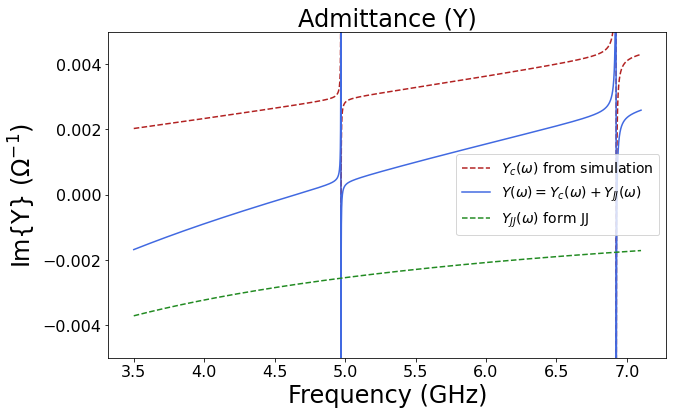

In [3]:
# L_J = 11.5e-9 #Henries
L_J = 12e-9 #Henries

freqs = array(data[0])*1e9 #HFSS gives frequency in GHz
#print(len(freqs))
Y_imag = array(data[1])
Y_real = array(data[2])

figure(figsize=(10,6))
plot(freqs/1e9,Y_imag, '--', color = 'firebrick',  label = r'$Y_c(\omega)$ from simulation')


E_J = (c.h/(2*c.e))**2/(4*L_J*c.pi**2)
print ("E_J = %.3f GHz" %(E_J/c.h/1e9))
C_J = 3.5e-15 #Farads
E_CJ = c.e**2/(2*C_J)
print ("E_CJ = %.3f GHz" %(E_CJ/c.h/1e9))
Y_J = 1.0j*2.0*c.pi*freqs*C_J - 1.0j/(2.0*c.pi*freqs*L_J)
Y_imag += imag(Y_J)
plot(freqs/1e9,Y_imag, color = 'royalblue', label = r'$Y(\omega) = Y_c(\omega) + Y_{JJ}(\omega)$')
plot(freqs/1e9, imag(Y_J), '--', color = 'forestgreen',  label = r'$Y_{JJ}(\omega)$ form JJ')
legend(fontsize=14, loc='center right')
xlabel('Frequency (GHz)', size=24)
ylabel('Im{Y} ($\Omega^{-1}$)', size=24)
title('Admittance (Y)', size=24)
ylim(-0.005,0.005)

## Linearization

![](http://journals.aps.org/prl/article/10.1103/PhysRevLett.108.240502/figures/2/large)

Caption quoted from paper: "(a) Schematics of a JJ ((red) boxed cross) coupled to an arbitrary linear circuit (striped disk). (b) The Josephson element is replaced by a parallel combination of: a linear inductance $L_J$, a linear capacitance $C_J$ and a purely nonlinear element with energy $E_J[1−cos(\varphi)]−(E_J/2)\varphi^2$, represented by the spider symbol. (c) The linear part of the circuit shown in (b) is lumped into an impedance $Z(\omega)$ seen by the nonlinear element. (d) Foster-equivalent circuit (pole-decomposition) of the impedance $Z(\omega)$."

Central to the black-box calculation is a linearization assumption; namely, the the circuit is treated as a linear $RLC$ circuit, with the non-linearity of the junction reintroduced as a perturbation. After partitioning the Josephson junction into its linear and nonlinear components (b), we group the linear elements of the circuit together to and calculate the effective impedence between the blue nodes in (c). Finally, Foster's Thereom allows us to calculate the impedence as the sum of the effective lumped impedences of the modes $p$ of the circuit:
$$ Z(\omega) = \sum_{p=1}^M \left( j\omega C_p + \frac{1}{j\omega L_p} + \frac{1}{R_p} \right)^{-1} $$

Since it is easier in general to work with zeroes instead of poles, we use the admittance, $Y(\omega) = Z(\omega)^{-1}$, for convenience in our calculations.

The resonance frequencies of the linear circuit are given by the real parts of the poles of the impedence, or conversely the zeroes of the admittance, while the imaginary parts give the width of the poles or, effectively, the decay rate. 

Mode Frequencies: [4.64791583 4.98058245 6.92992239] GHz


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

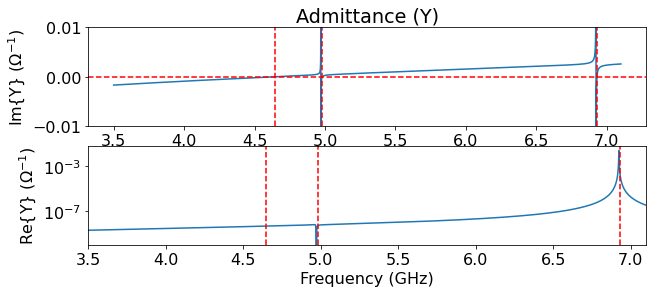

In [4]:
figure(figsize=(10,4))
subplot(211,xlabel = 'Frequency (GHz)',ylabel = 'Im{Y} ($\Omega^{-1}$)')
plot(freqs/1e9,Y_imag)

def find_roots_monotonic(X_array,Y_array):
    roots = array([])
    for i,x in enumerate(X_array):
        if i == 0:
            pass
        elif (Y_array[i]>0.0 and Y_array[i-1]<0.0):
            roots = append(roots,x)
        else:
            pass
    return roots
f_p = find_roots_monotonic(freqs,Y_imag)

for f in f_p:
    axvline(f/1e9,ls='dashed',color='r')
ylim(-0.01,0.01)
# xlim(min(freqs/1e9),max(freqs/1e9))
# xlim(f_p[0]/1e9-0.02, f_p[0]/1e9+0.02)
axhline(0,ls='dashed',color='r')
title('Admittance (Y)')
print ('Mode Frequencies: %s GHz' %(f_p/1e9))


subplot(212,xlabel = 'Frequency (GHz)',ylabel = 'Re{Y} ($\Omega^{-1}$)')
semilogy(freqs/1e9,Y_real)
xlim(min(freqs/1e9),max(freqs/1e9))
# xlim(9.47,9.485)
# axvline(9.191)
for f in f_p:
    axvline(f/1e9,ls='dashed',color='r')
# ylim(0,1e-9)

tight_layout

The effective resistance, capacitance, and inductance for the lumped elements of the model circuit in (d) can be calculated from the admittance as follows: $$R_p = \frac{1}{\text{ Re }Y(\omega_p))}, \text{ } C_p = \tfrac{1}{2}\text{ Im }Y'(\omega_p), \text{ } L_p = \frac{1}{2\omega_p^2 \text{ Im }Y'(\omega_p)}$$
These elements become useful for future calculations.

In [5]:
dY_imag = zeros(len(Y_imag)) 
fstep = 2*c.pi*(freqs[1] - freqs[0])
for i,y in enumerate(Y_imag):
    if i==0:
        dY_imag[i] = (Y_imag[i+1]-y)/(2*c.pi*(freqs[i+1] - freqs[i]))
    elif i==(len(Y_imag)-1):
        dY_imag[i] = (y-Y_imag[i-1])/(2*c.pi*(freqs[i] - freqs[i-1]))
    else:
        dY_imag[i] = ((Y_imag[i+1]-y)/(2*c.pi*(freqs[i+1] - freqs[i]))+(y-Y_imag[i-1])/(2*c.pi*(freqs[i] - freqs[i-1])))/2.0

R_p = array([])
for f in f_p:
    for i,x in enumerate(freqs):
        if f==x:
            R_p = append(R_p,1.0/(Y_real[i]))
        else:
            pass

C_p = array([])
for f in f_p:
    for i,x in enumerate(freqs):
        if f==x:
            C_p = append(C_p,dY_imag[i]/2.0)
        else:
            pass

L_p = array([])
for f in f_p:
    for i,x in enumerate(freqs):
        if f==x:
            L_p = append(L_p,2.0/((2*pi*x)**2*dY_imag[i]))
        else:
            pass

Z_p = sqrt(L_p/C_p)

Gq = 4*pi*c.e**2/c.h

Phi_p = sqrt(Gq*Z_p) 

# print ('Qubit Index = %s' %(q_index))
print ('Mode resistances: %s Ohms' %R_p)
print ('Mode capacitances: %s F' %C_p)
print ('Mode inducatances: %s H' %L_p)
print ('Mode impedences: %s Ohm' %Z_p)
print ('Dimensionless mode phase fluctuation: %s ' %Phi_p)

Q_p = array([])
for f,R,C in zip(f_p,R_p,C_p):
    Q_p = append(Q_p,2*c.pi*f*R*C)
print ('Mode Q\'s: %s' %Q_p)

Mode resistances: [2.15194978e+08 1.96519978e+08 4.26157048e+03] Ohms
Mode capacitances: [1.04446022e-13 3.14815954e-12 2.82673264e-11] F
Mode inducatances: [1.12261761e-08 3.24356991e-10 1.86594478e-11] H
Mode impedences: [327.84606422  10.15040253   0.81246943] Ohm
Dimensionless mode phase fluctuation: [0.39950507 0.07029573 0.01988799] 
Mode Q's: [6.56390305e+05 1.93608064e+07 5.24520720e+03]


In [6]:
#loop through number of included levels

N = len(Z_p)
nlev = 10
a_p = []
for i in range(N):
    if i == 0:
        a = destroy(nlev)
    else:
        a = qeye(nlev)
    for j in range(1,N):
        if j == i:
            a = tensor(a,destroy(nlev))
        else:
            a = tensor(a,qeye(nlev))
    a_p.append(a)

    
ej = (2*pi*E_J/c.h/1e9)

H0 = 0
Hnl = 0

for i in range(N):
    H0 = H0 + (2*pi*f_p[i]/1e9)*a_p[i].dag()*a_p[i]
    Hnl = Hnl + Phi_p[i]*(a_p[i] + a_p[i].dag())

# H0 = sum([(2*pi*f_p[i]/1e9)*a_p[i].dag()*a_p[i] for i in range(N)])

# Hnl4 = -ej/24*(sum([Phi_p[i]*(a_p[i] + a_p[i].dag()) for i in range(N)]))**4

# Hnl6 = ej/720*(sum([Phi_p[i]*(a_p[i] + a_p[i].dag()) for i in range(N)]))**6

# Hnl8 = -ej/40320*(sum([Phi_p[i]*(a_p[i] + a_p[i].dag()) for i in range(N)]))**8

H = H0 -ej/24*Hnl**4 + ej/720*Hnl**6 -ej/40320*Hnl**8

jc_energies=(H.eigenstates()[0] - H.eigenstates()[0][0])
jc_vectors=(H.eigenstates()[1])
print(len(jc_energies)) # nlev**N, so energy levels to the number of modes of the sistem
print (jc_energies/(2*pi))
# print(jc_vectors)

n_vecs = array([array([expect(a_p[i].dag()*a_p[i], jc_vector) for jc_vector in jc_vectors]) for i in range(N)])
# print(n_vecs)

def find_freq(occs,n_vecs = n_vecs,e_vec = jc_energies):
    return jc_energies[argmin([sum(abs(n_vecs.T[i]-occs)) for i in range(len(jc_energies))])]/(2*pi)

# print ('with phi8 and phi6')
qi = 0
alpha_q = -find_freq([2,0,0]) + 2*find_freq([1,0,0])
alpha_s = -find_freq([0,2,0]) + 2*find_freq([0,1,0])
alpha_r = -find_freq([0,0,2]) + 2*find_freq([0,0,1])
alpha_list = [alpha_q, alpha_s, alpha_r]

two_chi_storage = (find_freq([0,1,0]) - find_freq([0,0,0])) - (find_freq([1,1,0]) - find_freq([1,0,0]))
two_chi_readout = (find_freq([0,0,1]) - find_freq([0,0,0])) - (find_freq([1,0,1]) - find_freq([1,0,0]))

print('2X_readout =', '(', find_freq([0,0,1]),'-', find_freq([0,0,0]),') - (',find_freq([1,0,1]), '-', find_freq([1,0,0]),')) =',two_chi_readout) 
print('2X_storage =', '(', find_freq([0,1,0]),'-', find_freq([0,0,0]),') - (',find_freq([1,1,0]), '-', find_freq([1,0,0]),')) =',two_chi_storage)

qubit_freq = find_freq([1,0,0])
storage_freq = find_freq([0,1,0])
readout_freq = find_freq([0,0,1])

g_storage = sqrt(two_chi_storage/2/alpha_q*(qubit_freq-storage_freq)*(qubit_freq-storage_freq+alpha_q))
g_readout = sqrt(two_chi_readout/2/alpha_q*(qubit_freq-readout_freq)*(qubit_freq-readout_freq+alpha_q))
purcell_t1 = Q_p[qi]/(2*c.pi*f_p[qi])

readout_Q = 30e3
purcT1 = 1/((g_readout/(readout_freq-qubit_freq))**2 * (2*c.pi*readout_freq*1e9)/readout_Q)

1000
[  0.           4.45881012   4.97689166   6.92949495   8.71706243
   9.43217249   9.95375831  11.38754779  11.90637722  12.75646433
  13.68900629  13.8589891   14.40554605  14.93060043  15.64511966
  16.3609106   16.56679697  16.8832346   17.7278027   18.31628497
  18.66095655  18.83586199  19.37893042  19.68390136  19.90741849
  20.19962048  20.61706494  20.78848244  21.33428451  21.53929835
  21.86006761  22.57317654  22.69915042  23.28964821  23.4936929
  23.63291302  23.81271016  23.86560423  24.35232522  24.65524053
  24.88421296  25.18203362  25.24502166  25.58901657  25.765346
  26.30766913  26.5119022   26.61133807  26.83687669  27.12614612
  27.54512321  27.67050898  27.71797498  27.95585247  28.26302245
  28.46619778  28.60487558  28.78953407  28.92243404  29.3257301
  29.50123307  29.62658923  29.86098441  30.16627429  30.21838531
  30.42058863  30.56097437  30.74218497  30.79214684  31.2810641
  31.48461615  31.582678    31.81366231  32.10857109  32.17375786
  32.51707

From the cross-Kerr shift, you can estimate the effective resonant vacuum Rabi rate, $g_p$, between the qubit and mode $p$: 
$$ g_p = \sqrt{\chi_{qp} \Delta_{qp} \frac{\Delta_{qp} + \alpha_q}{\alpha_q}} $$

In [7]:

# print ('Qubit Index = %s' %(q_index))
print ("Qubit Freq = %s GHz" %around(qubit_freq, decimals=3))
E_J_hz = E_J/c.h
print ('E_J = %s GHz' %around(E_J_hz/1e9, decimals=3))

E_C = c.e**2/(2*C_p[qi])/c.h #E_C in Hz
print ('E_C: %s MHz' %around(E_C/1e6, decimals=3))
print ('E_J/E_C: %s' %around(E_J_hz/E_C,decimals=3))

e1 = E_C*2**9*sqrt(2/c.pi)*(E_J_hz/(2*E_C))**(5/4) * exp(-sqrt(8*E_J_hz/E_C)) #first energy state charge dispersion
# print ('Epsilon1: %s kHz' %around ( e1/1e3 ,decimals=3))
print ('Charge Dispersion T2: %s us' %around (1/e1 *1e6, decimals=3))

print ("Qubit Anharmonicity = %s MHz" %around(alpha_list[qi]*1e3, decimals=3))
# print ("Readout Anharmonicity = %s Hz" %around(alpha_list[2]*1e9, decimals=6))

print ("2XChi storage = %s MHz" %around(two_chi_storage*1e3, decimals=3))
print("g storage = %s MHz" %around(g_storage*1e3, decimals=3))

print ("storage Freq = %s GHz" %around(storage_freq, decimals=3))
print ("storage Delta = %s GHz" %around(storage_freq-qubit_freq, decimals=3))

print ("2XChi readout = %s MHz" %around(two_chi_readout*1e3, decimals=3))
print("g readout = %s MHz" %around(g_readout*1e3, decimals=3))

# print("Purcell T1 = %s us" %around(purcell_t1*1e6, decimals=3))
print ("Readout Freq = %s GHz" %around(readout_freq, decimals=3))
print ("Readout Delta = %s GHz" %around(readout_freq-qubit_freq, decimals=3))

print("Readout Linewidth = %s MHz" %around(1e3*(readout_freq)/readout_Q, decimals=3))
print("Purcell T1 estimate = %s us" %around(purcT1*1e6, decimals=3))

Qubit Freq = 4.459 GHz
E_J = 13.622 GHz
E_C: 185.457 MHz
E_J/E_C: 73.45
Charge Dispersion T2: 4918.577 us
Qubit Anharmonicity = 200.558 MHz
2XChi storage = 3.529 MHz
g storage = 38.045 MHz
storage Freq = 4.977 GHz
storage Delta = 0.518 GHz
2XChi readout = 0.757 MHz
g readout = 102.903 MHz
Readout Freq = 6.929 GHz
Readout Delta = 2.471 GHz
Readout Linewidth = 0.231 MHz
Purcell T1 estimate = 397.209 us
